# Разработка модели, выявляющей токсичные комментарии

**Цель проекта**

Построение модели, способной классифицировать комментарии на позитивные и негативные со значением метрики качества *F1* не меньше 0.75. 

**Этапы работы**

1. Разведочный анализ.
2. Лемматизация, удаление стоп-слов.
3. Векторизация с помощью TF-IDF.
4. Построение модели. 
5. Выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from tqdm import notebook
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
import logging

import spacy
import re
import nltk

In [2]:
# Импортируем библиотеку imbalanced-learn, для сэмплирования
try:
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline
except:
    !pip install scikit-learn --upgrade -q
    !pip install imbalanced-learn --upgrade -q
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline

In [3]:
# Импортируем модули из sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import make_classification
from sklearn.base import BaseEstimator, ClassifierMixin

In [4]:
# Импортируем библиотеку optuna, для гиперпараметров, (если она не установлена, устанавливаем)
try:
    import optuna
except:
    !pip install optuna -q
    import optuna

In [5]:
# Загрузка английской модели spacy
nlp = spacy.load("en_core_web_sm")

# Загрузка списка стоп-слов
nltk.download('stopwords', quiet=True)
stop_words = set(nltk.corpus.stopwords.words('english'))

In [6]:
# Убираем необязательные предупреждения
warnings.filterwarnings('ignore')

# Настраиваем отображение всех строк таблицы
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Задаём стандартне параметры для графиков
plt.rcParams['figure.figsize'] = (13, 5)
plt.rcParams.update({'font.size':'12'})

# Устанавливаем уровень логирования для transformers на ERROR, чтобы скрыть предупреждения
logging.getLogger("transformers").setLevel(logging.ERROR)

# Скрываем журнал с триалами
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [7]:
RANDOM_STATE = 42

## Функции и классы

### Класс для TF-IDF

In [8]:
class TfIdf:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            min_df=2,
            max_df=0.7,
            stop_words='english',
            sublinear_tf=True
        )

    def fit_transform(self, corpus):
        tf_idf_corpus = self.vectorizer.fit_transform(corpus)
        return tf_idf_corpus

    def transform(self, corpus):
        tf_idf_corpus = self.vectorizer.transform(corpus)
        return tf_idf_corpus

### Класс для добавления порогового значения в пайплайн

In [9]:
class ThresholdLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, model, threshold=0.5):
        self.model = model
        self.threshold = threshold
    
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

### Функция для лемматизации и исключения стоп-слов

In [10]:
def lemmatize_texts(texts):
    lemmatized_texts = []
    
    for text in notebook.tqdm(texts, desc="Transforming"):
        # Обработка текста
        doc = nlp(text.lower())

        # Извлечение лемм
        lemmas = [token.lemma_ for token in doc]

        # Фильтрация лемм, исключая стоп-слова
        lemmas_no_stopwords = [lemma for lemma in lemmas if lemma not in stop_words]

        # Удаление знаков препинания и нежелательных символов
        cleaned_lemmas = [re.sub(r'[^a-zA-Z\s]', '', lemma) for lemma in lemmas_no_stopwords]

        # Удаление слов "talk" и "UTC"
        final_lemmas = [lemma for lemma in cleaned_lemmas if lemma not in ['talk', 'utc']]

        # Преобразование списка лемм в строку и удаление лишних пробелов
        processed_text = " ".join(final_lemmas).split()
        processed_text = " ".join(processed_text)
        
        # Если строка пустая, заменяем её на emptyplaceholder
        if not processed_text:
            processed_text = "emptyplaceholder"

        lemmatized_texts.append(processed_text)

    return np.array(lemmatized_texts)

### Функции для нахождения лучшего порогового значения

In [11]:
def get_best_threshold(model, X, y):
    y_pred_proba = model.predict_proba(X)[:,1]
        
    y_pred = pd.DataFrame({'proba': y_pred_proba})
 
    therhold_list = []
    f1_metric_list = []
    for i in np.arange(0.1, 0.9, 0.01):
        therhold_list.append(i)
        y_pred['pred'] = y_pred['proba'].apply(lambda x: 0 if x < i else 1)
        f1_metric = f1_score(y, y_pred['pred'])
        f1_metric_list.append(f1_metric)
 
    threshold_pred_df = pd.DataFrame({'threhold': therhold_list, 
                                    'f1_metric': f1_metric_list})

    best_threshold_pred_df = (
        threshold_pred_df[threshold_pred_df['f1_metric'] == threshold_pred_df['f1_metric'].max()]
        .reset_index(drop=True)
    )
    
    best_threshold = best_threshold_pred_df.loc[0, 'threhold']
    return best_threshold

In [12]:
def stratified_and_get_threshold(model, X_train, y_train, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    thresholds = []
    for fold_idx, (train_index, val_index) in notebook.tqdm(
        enumerate(skf.split(X_train, y_train)), total=n_splits, desc='Search'):
        # Выделяем текущий фолд как валидационную выборку
        X_val_treshold = X_train[val_index]
        y_val_treshold = y_train[val_index]

        # Оставшиеся фолды составляют обучающую выборку
        X_train_treshold = X_train[train_index]
        y_train_treshold = y_train[train_index]
        
        # Обучаем модель
        model.fit(X_train_treshold, y_train_treshold)
        
        # Получаем лучшее пороговое значение и сохраняем в список
        threshold = get_best_threshold(model, X_val_treshold, y_val_treshold)
        thresholds.append(threshold)
    
    # Возвращаем среднее пороговое значение по кроссвалидации
    best_threshold = np.array(thresholds).mean()
    return best_threshold

## Загрузка данных

In [13]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
    print(f'Данные были успешно загружены, с сайта, размер датасета: {data.shape}')
except:
    data = pd.read_csv('datasets\\toxic_comments.csv')
    print(f'Данные были успешно загружены из файла, размер датасета: {data.shape}')

Данные были успешно загружены из файла, размер датасета: (159292, 3)


In [14]:
data.sample(1)

,Unnamed: 0,text,toxic
150047,150203,"""* Template talk:R help#""""Like"""" a /doc page\n""",0


Удалим лишнюю колонку.

In [15]:
data = data[['text', 'toxic']]
data.sample(1)

,text,toxic
67335,New CEO. \n\n(Already put this on the Talk: Ja...,0


**Посмотрим пример текста.**

In [16]:
data.loc[7, 'text']

"Your vandalism to the Matt Shirvington article has been reverted.  Please don't do it again, or you will be banned."

**Посмотрим распределение целевого признака.**

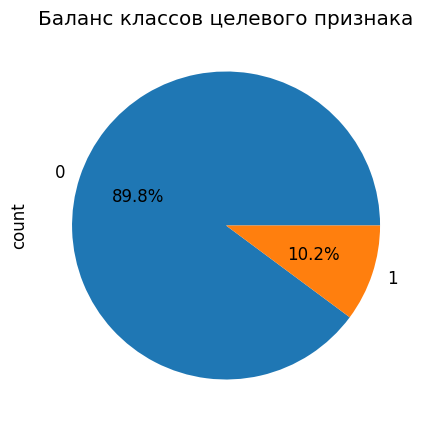

In [17]:
data['toxic'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Баланс классов целевого признака')
plt.show()

**Вывод:**

- Данные были загружены, данные соответствуют описанию.
- Токичных комментариев всего 10% от общего числа.

## Подготовка данных

**Сразу раздем датасет на тренировочную и тестовую выборки**

In [18]:
# Разделение данных на тренировочную и тестовую выборки с сохранением соотношения классов
train_text, test_text = train_test_split(
    data, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=data['toxic']
)

# Проверяем результат
print(f"Размер тренировочной выборки: {len(train_text)}")
print(f"Размер тестовой выборки: {len(test_text)}")

Размер тренировочной выборки: 127433
Размер тестовой выборки: 31859


**Разбиваем выборки на features и target.**

In [19]:
X_train_text = train_text['text'].values
y_train = train_text['toxic'].values

print(X_train_text.shape)
print(y_train.shape)

(127433,)
(127433,)


In [20]:
X_test_text = test_text['text'].values
y_test = test_text['toxic'].values

print(X_test_text.shape)
print(y_test.shape)

(31859,)
(31859,)


**Лемматизируем выборки и исключаем стоп-слова.**

In [21]:
X_train_text = lemmatize_texts(X_train_text)
X_train_text.shape

Transforming:   0%|          | 0/127433 [00:00<?, ?it/s]

(127433,)

In [22]:
X_test_text = lemmatize_texts(X_test_text)
X_test_text.shape

Transforming:   0%|          | 0/31859 [00:00<?, ?it/s]

(31859,)

**Смотрим и убираем дубоикаты из тренировочной выборки.**

In [23]:
train_text = pd.DataFrame({'features': X_train_text, 'target': y_train})
print("Количество дубликатов:", train_text.duplicated().sum())

Количество дубликатов: 1450


In [24]:
train_text = train_text.drop_duplicates().reset_index(drop=True)
print("Количество дубликатов:", train_text.duplicated().sum())

Количество дубликатов: 0


In [25]:
X_train_text = np.array(train_text['features'])
y_train = np.array(train_text['target'])
print(X_train_text.shape)
print(y_train.shape)

(125983,)
(125983,)


**Конвертируем лемматизированный текст в разряженную числовую матрицу.**

In [26]:
words_vectoriser = TfIdf()

In [27]:
X_train = words_vectoriser.fit_transform(X_train_text)
X_train.shape

(125983, 52807)

In [28]:
X_test = words_vectoriser.transform(X_test_text)
X_test.shape

(31859, 52807)

## Обучение моделей

**Подбираем параметры и тестируем LogisticRegression.**

In [29]:
# Определение функции для подбора гиперпараметров
def objective(trial):
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'C': trial.suggest_float('C', 0.01, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'lbfgs']),
    }
    
    # Создание пайплайна, включающего ресэмплинг и модель
    pipeline = Pipeline([
        ('sampling', RandomUnderSampler(random_state=RANDOM_STATE)),
        ('model', LogisticRegression(**params, random_state=RANDOM_STATE))
    ])
    
    # Кросс-валидация пайплайна
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    auc = cv_results.mean()
    
    return auc

# Инициализация и запуск Optuna
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=5, show_progress_bar=True)

# Обучение пайплайна с лучшими гиперпараметрами на всех данных
best_params = study.best_params

# Создаём модель
logistic_model = LogisticRegression(**best_params, random_state=RANDOM_STATE)

# Создаём пайплайн
pipeline = Pipeline([
    ('sampling', RandomUnderSampler(random_state=RANDOM_STATE)),
    ('model', logistic_model)
])

pipeline.fit(X_train, y_train)

  0%|          | 0/5 [00:00<?, ?it/s]

Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('model',
                 LogisticRegression(C=3.142880890840109, random_state=42,
                                    solver='liblinear'))])

**Подбираем оптимальное пороговое значение.**

In [30]:
best_threshold = stratified_and_get_threshold(pipeline, X_train, y_train)
print(f'Оптимальный порог для максимизации метрики F1: {best_threshold:.4f}')

Search:   0%|          | 0/5 [00:00<?, ?it/s]

Оптимальный порог для максимизации метрики F1: 0.7200


**Добавляем пороговое значение в пайплайн.**

In [31]:
# Создаём модель с новым пороговым значением
threshold_model = ThresholdLogisticRegression(
    model=logistic_model,
    threshold=best_threshold
)

# Создаём итоговый пайплайн с моделью, учитывающей оптимальное пороговое значение
final_pipe = Pipeline([
    ('sampling', RandomUnderSampler(random_state=RANDOM_STATE)),
    ('model', threshold_model)
])

**Тестируем итоговый пайплайн на тренировочной выборке.**

In [32]:
final_pipe.fit(X_train, y_train)
preds = final_pipe.predict(X_test)
score = f1_score(y_test, preds)
print(f'Метрика f1 на тестовой выборке: {score:.4f}')

Метрика f1 на тестовой выборке: 0.7739


## Выводы

Была разработана модель, определяющая токсичность комментариев. 

Метрика F1 на тестовой выборке равна 0.77, что удовлетворяет требованию заказчика (минималоьный порог 0.75).

Предобработка текстов состоит из 2 этапов:
- лемматизация текстов, удаление стоп-слов
- векторизация лемматизированных текстов методом TF-IDF

Процесс лемматизации может занимать достаточно продолжительное время (около получаса на тренировочной выборке).